<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/generative-models/samples/DPM_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Resources

- https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/08_diffusion/01_ddm/ddm.ipynb

## Imports

In [281]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import Tensor
from torchvision import datasets
import torchvision.transforms.v2 as T

## Parameters

## Dataset

In [282]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((64, 64)),
    T.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [283]:
def inv_norm():
    return lambda x: x*255.0

In [284]:
inv_transform = T.ToPILImage()

In [285]:
ds = datasets.Flowers102(
    root="./data/flowers/",
    split="train",
    transform=transform,
    download=True,
)

In [286]:
sample = ds[0][0]
print(f"{sample.shape = }")

sample.shape = torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


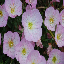

In [287]:
out = inv_transform(sample)
out

## Diffusion

### Schedule

In [288]:
steps = 1000

In [289]:
def linear_diffusion_schedule(
    steps: int,
    min_step_error_rate: float = 1e-4,
    max_step_error_rate: float= 2e-2,
):
    betas = torch.linspace(min_step_error_rate, max_step_error_rate, steps+1)
    alphas = 1 - betas
    alpha_bars = torch.cumprod(alphas, 0)
    signal_rates = torch.pow(alpha_bars, 0.5)
    noise_rates = 1 - signal_rates
    return noise_rates, signal_rates

In [290]:
def cosine_diffusion_schedule(
    steps: int,
):
    times = torch.linspace(0, 1, steps+1)
    signal_rates = torch.cos(times * np.pi * 0.5)
    noise_rates = torch.sin(times * np.pi * 0.5)
    return noise_rates, signal_rates

In [294]:
def cosine_diffusion_schedule_with_offset(
    steps: int,
    min_signal_rate: float = 0.02,
    max_signal_rate: float = 0.95,
):
    start_angle, end_angle = np.arccos(max_signal_rate), np.arccos(min_signal_rate)
    times = torch.linspace(0, 1, steps+1)
    angles = start_angle + times * (end_angle - start_angle)
    signal_rates = torch.cos(angles)
    noise_rates = torch.sin(angles)
    return noise_rates, signal_rates

In [295]:
nr_lin, sr_lin = linear_diffusion_schedule(steps)
nr_cos, sr_cos = cosine_diffusion_schedule(steps)
nr_cos_off, sr_cos_off = cosine_diffusion_schedule_with_offset(steps)

Text(0, 0.5, '$\\bar{\\alpha}_t$ (signal)')

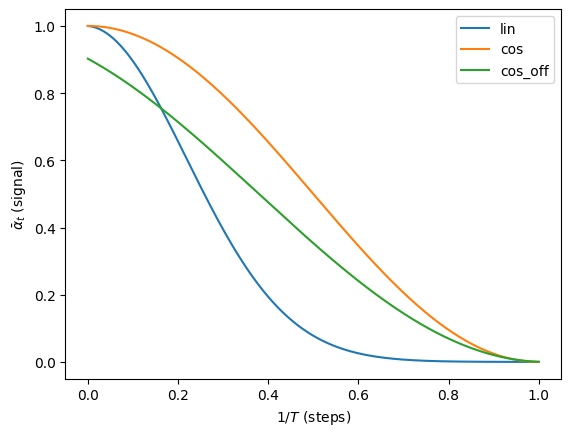

In [305]:
x = np.linspace(0, 1, steps+1)
plt.plot(x, sr_lin**2)
plt.plot(x, sr_cos**2)
plt.plot(x, sr_cos_off**2)
plt.legend(["lin", "cos", "cos_off"])
plt.xlabel(r'$1/T$ (steps)')
plt.ylabel(r'$\bar{\alpha}_t$ (signal)')